# Hilbert Huang Transform

After having explored the spectrogram representation, let's move on to the an alternative time-frequency representation known as the Hilbert Huang Transform, or HHT. Unlike the Fourier transform, which was developed as a theoretical tool, the HHT is an algorithmic/empirical/data-driven approach designed to work effectively for nonstationary and nonlinear time series. At its core, the HHT involves decomposing a signal into intrinsic mode functions (IMFs), via a process known as empirical mode decomposition (EMD).

This [paper](https://asa.scitation.org/doi/10.1121/1.2354003) offers insight into the application of HHTs to marine mammal bioacoustics, and [this](https://www.sciencedirect.com/science/article/abs/pii/S0003682X06000764) one addresses the use of HHTs to investigate transient sperm whale clicks, in particular. The HHT approach to bioacoustics demonstrates several advantages over conventional spectrogram-based approaches. These include (1) improved temporal and spectral resolution relative to the STFT spectrogram approach, since the HHT is not theoretically confined by the uncertainty principle; (2) the original signal decomposition into successive modes is complete; and (3) the frequency evolution for each mode can be analyzed as a one-dimensional (1D) signal. With this brief introduction, let's get started with this algorithm.

We begin with a few imports:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from PyEMD import EMD
from scipy.signal import hilbert
from scipy import interpolate

Next, we'll load the Watkins sperm whale coda (``_sw``) and, as before, plot a single click for completeness. We'll also use the orca N01 call (``_orca``) for comparison.

In [2]:
file = 'data/WatkinsPMacro.wav'
wf, sr_sw = sf.read(file)
signal_sw = wf[25000:45000]
time_sw = np.linspace(0,len(signal_sw)/sr_sw,len(signal_sw))

In [5]:
path_name = '../../.fastai/data/orchive-dataset.tar/call-catalog-xsilence/N01/A36-N01-062802-D004-12218.aiff'
signal_orca, sr_orca = sf.read(path_name)
time_orca = np.linspace(0,len(signal_orca)/sr_orca,len(signal_orca))

Now the fun begins! Briefly, we'll give a synopsis of the mathematics involved in carrying out the HHT. The procedure begins with empirical mode decomposition (EMD) using this [textbook](https://www.cambridge.org/core/books/passive-acoustic-monitoring-of-cetaceans/8D59083194B2634B9F490635EAF23653) as a reference. This entails decomposing the original signal $x(t)$ into a series of oscillating functions $C_n(t)$ and a non-oscillatory final trend $R_N(t)$.

$$x(t) = \sum_{n=1}^NC_n(t) + R_N(t)$$

The $C_n(t)$ functions are called intrinsic mode functions (IMFs), and they are characterized by a decreasing number of zero crossings with increasing $n$.

Here, we'll make use of the ``EMD`` method in the ``PyEMD`` module to plot the IMFs for the signals.

In [6]:
labels = ['Sperm Whale', 'Orca']
signals = [signal_sw, signal_orca]
times = [time_sw, time_orca]
srs = [sr_sw, sr_orca]

In [7]:
emd = EMD()
imfs_sw_orca = [emd(signal_sw), emd(signal_orca)]

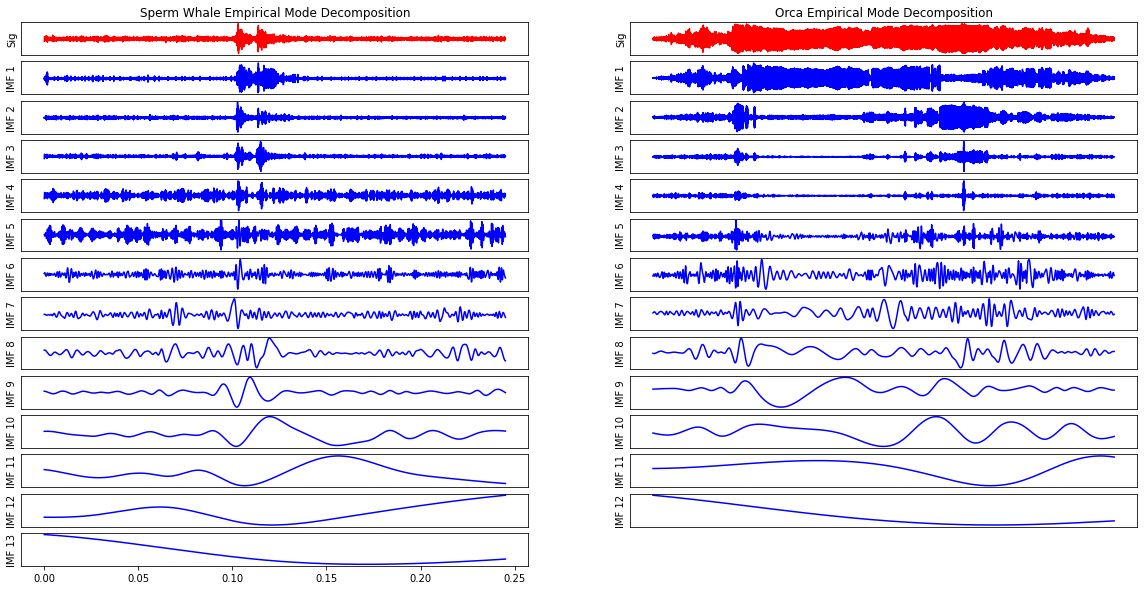

In [8]:
n_max = 13
fig, axs = plt.subplots(n_max+1, 2, figsize=(20,10))
for idx, imfs in enumerate(imfs_sw_orca):
    label = labels[idx]
    signal = signals[idx]
    time = times[idx]
    
    axs[0, idx].plot(time, signal, color='r')
    axs[0, idx].set_xticks([])
    axs[0, idx].set_yticks([])
    axs[0, idx].set_ylabel('Sig')
    axs[0, idx].set_title(f'{label} Empirical Mode Decomposition')
    
    try:
        for i in range(n_max):
            axs[i+1, idx].plot(time, imfs[i,:], color='blue')
            axs[i+1, idx].set_ylabel(f'IMF {i+1}')
            axs[i+1, idx].set_yticks([])
            if i < n_max-1:
                axs[i+1, idx].set_xticks([])
            if i == n_max:
                axs[i+1, idx].set_xlabel('Time (s)')
    except IndexError:
        fig.delaxes(axs[-1][1])
plt.show()

Following this decomposition, can proceed with the HHT. In the following, we'll let $s(n)$ represent the value of the signal at time step $n$, since we are working with discrete time series. The Hilbert transform of a signal (denoted $s_H(n)$) is obtained by convolving the signal with $\frac{1}{\pi n}$:

$$s_H(n) = s(n) \ast \frac{1}{\pi n}$$

Next, we define the analytic signal $s_A(n)$:

$$s_A(n) = s(n) + i s_H(n) = a(n)e^{i\theta(n)} \hspace{2mm} \text{where} \hspace{2mm} a(n) \equiv \sqrt{s^2(n) + s_H^2(n)} \hspace{2mm} \text{and} \hspace{2mm} \theta(n)\equiv \arctan{[s_H(n) / s(n)]}$$

From this, we obtain the instantaneous frequency at each time step $n$ by evaluating:

$$f(n) = \frac{1}{2\pi}\frac{d\theta(n)}{dn}$$

With this framework in place, we'll define our own custom class to carry out this transform.

In [9]:
class HHT(object):
    
    def __init__(self, signal, time, fs):
        self.signal = signal
        self.time = time
        self.fs = fs
        
    def emd(self):
        calc_emd = EMD()
        imfs = calc_emd(self.signal)
        return imfs
    
    def ht(self, t_res=128, f_res=256, ylim=20000, amin=1e-2):
        s = self.signal
        t = self.time
        N = len(t)
        Ts = 1 / self.fs
        
        t_bins = np.linspace(0, np.max(t), t_res)
        t_dig = np.digitize(t, t_bins)-1
        
        f_bins = np.linspace(0, 16, f_res)
        f_bins = 2**f_bins
        
        imfs = self.emd()
        K = imfs.shape[0]
        
        HS = np.zeros((t_res, f_res))
        for i in range(K):
            x = imfs[i, :]

            H = hilbert(x)
            H_imag = H.imag
            H_amp = np.abs(H)

            dH_imag = np.diff(H_imag)
            dH_imag = np.insert(dH_imag, len(dH_imag), dH_imag[-1])

            dx = np.diff(x)
            dx = np.insert(dx, len(dx), dx[-1])

            w = (x*dH_imag - H_imag*dx) / (H_amp**2)
            freq = w*self.fs / (2*np.pi)

            f_dig = np.digitize(freq, f_bins)

            for idx in range(N):
                if f_dig[idx] < f_res:
                    HS[t_dig[idx], f_dig[idx]] += H_amp[idx]

        HS_dB = 20*np.log10(HS + amin)
        
        tt, ff = np.meshgrid(t_bins, f_bins)
        
        return tt, ff, HS_dB
    
    def interp_rep(self, ts, fs, hs, n_points=1000, ylim=20000):
        f = interpolate.RectBivariateSpline(ts, fs, hs)

        t_interp = np.linspace(0, ts[-1], n_points)
        f_interp = np.linspace(0, fs[-1], n_points)

        hs_interp = f(t_interp, f_interp)

        tt, ff = np.meshgrid(t_interp, f_interp)
        return tt, ff, hs_interp
    
    def plot_rep(self, t_mesh, f_mesh, HS_arr, ylim=20000, interp=False, vis_details=True, vis=True):
        
        if interp:
            t_mesh, f_mesh, HS_arr = self.interp_rep(t_mesh[0, :], f_mesh[:, 0], HS_arr, ylim=ylim)
        fig = plt.figure()
        plt.pcolormesh(t_mesh, f_mesh, HS_arr.T, cmap='magma')
        plt.ylim([0, ylim])
        if vis_details:
            plt.xlabel('Time (s)')
            plt.ylabel('Frequency (Hz)')
            plt.title('Hilbert Huang Spectrum')
        else:
            plt.xticks([])
            plt.yticks([])
        if vis:
            plt.show()

Cool! With our new ``HHT`` class, let's represent our sperm whale and orca signals. We'll first plot the Hilbert spectrum of the sperm whale click:

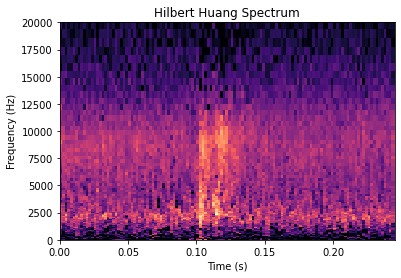

In [10]:
hht_sw = HHT(signal_sw, time_sw, sr_sw)
imfs_sw = hht_sw.emd()
tt_sw, ff_sw, HS_dB_sw = hht_sw.ht()
hht_sw.plot_rep(tt_sw, ff_sw, HS_dB_sw)

Looks good! Now let's interpolate it and remove the plot labels as if we are preparing for a machine learning application.

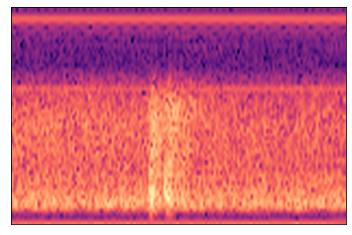

In [12]:
import scipy
def interp_spec(spec, freqs, ts, ylim=20000):
    interp_fx = interpolate.interp2d(t, f, 20*np.log10(spec), kind='cubic')
    
    ts_interp = np.linspace(t.min(), t.max(), 1000)
    freqs_interp = np.linspace(f.min(), ylim, 1000)
    spec_interp = interp_fx(ts_interp, freqs_interp)
    
    return spec_interp, freqs_interp, ts_interp

f, t, Sxx = scipy.signal.spectrogram(signal_sw, fs=sr_sw, window='hann', nperseg=256, noverlap=256//2, detrend=False, scaling='spectrum')
Sxx, f, t = interp_spec(Sxx, t, f)
plt.pcolormesh(t, f, Sxx, cmap='magma')
plt.xticks([])
plt.yticks([])
plt.show()

Finally, we'll adjust our goodness method and evaluate the goodness of these representations.

In [16]:
from sklearn.decomposition import PCA
from itertools import count
def rep_goodness(rep, n_pca=150, th=0.95, vis=True):
    pca = PCA(n_components=n_pca)
    pca.fit(rep)
    
    sum_ = 0
    for feature_i in count():
        sum_ += pca.explained_variance_ratio_[feature_i]
        if sum_ > th:
            break
    if vis:
        print(f'Number of Features to Exceed Threshold th={th}: {feature_i+1}')
    
    return feature_i+1

In [17]:
hht_sw = HHT(signal_sw, time_sw, sr_sw)
imfs_sw = hht_sw.emd()
tt_sw, ff_sw, HS_dB_sw = hht_sw.ht()
tt_sw, ff_sw, HS_dB_sw = hht_sw.interp_rep(tt_sw[0, :], ff_sw[:, 0], HS_dB_sw)
hht_goodness = rep_goodness(HS_dB_sw)

Number of Features to Exceed Threshold th=0.95: 51


In [18]:
spec_goodness = rep_goodness(Sxx)

Number of Features to Exceed Threshold th=0.95: 10


As we can see, the HHT approach yields a representation containing a greater number of salient features, as determined by a PCA approach! This is great, since we want to provide our ML models with meaningful representations from which the network can extract features enabling it to carry the particular tasks of interest.

As a last step, let's look at the orca signal using the HHT representation:

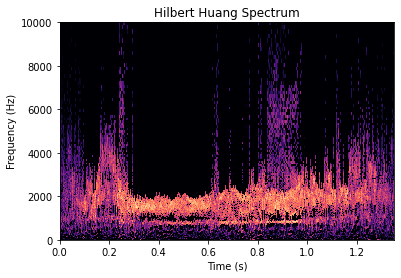

In [19]:
hht_orca = HHT(signal_orca, time_orca, sr_orca)
imfs_orca = hht_orca.emd()
tt_orca, ff_orca, HS_dB_orca = hht_orca.ht(t_res=512, f_res=512)
hht_orca.plot_rep(tt_orca, ff_orca, HS_dB_orca, ylim=10000)

And now the interpolated version without the plot labels:

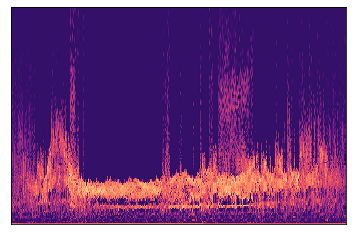

In [21]:
hht_orca.plot_rep(tt_orca, ff_orca, HS_dB_orca, ylim=10000, interp=True, vis_details=False)

This concludes our discussion ofthe HHT approach. Now let's move on to yet another, the continuous wavelet transform representation.